In [1]:
import pandas as pd
# http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf
#currently have 24 topics

In [12]:
data = pd.read_csv('../Data/RYANDATA_filt.csv')
data.columns = ['V0', 'topic', 'authors','title','journal','year','vol_issue','doi','abstract']


In [117]:
#split data keeping distribution
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits= 1, 
                             test_size = 0.2, 
                             random_state = 0)

for train_idx, test_idx in sss.split(data['title'],data['topic']):
    X_train, X_test = data['title'][train_idx], data['title'][test_idx]
    y_train, y_test = data['topic'][train_idx], data['topic'][test_idx]


# Preprocess data 

In [132]:
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
import numpy as np
np.random.seed(0)

# import nltk
# nltk.download('wordnet')

#tokenize, lemmatized, stemmed
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    result = ' '.join(result)        
    return result

doc_sample = X_train[0]
print('Original document: ')
words = []
for doc in [doc_sample]:
    print(doc)
print('\nTokenized and lemmatized document: ')
print(preprocess(doc_sample))

X_train_proc = X_train.map(preprocess)

Original document: 
Proximal radius fracture morphology following axial force impact: a biomechanical evaluation of fracture patterns

Tokenized and lemmatized document: 
proxim radius fractur morpholog follow axial forc impact biomechan evalu fractur pattern


# Vectorize data for NMF and LDA

In [133]:
#https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib
from sklearn.feature_extraction import text
#additional stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['biomechan','locomot'])
#Non-negative Matrix Factorization (NMF) likes TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=3, #min occurances needed
                             max_df=0.5, #max occuraces allowed (%)
                             ngram_range=(1,3), #size range of grams (1-2 words)
                             strip_accents='unicode',
                             lowercase =True,
                             analyzer='word', 
#                              token_pattern=r'\w+', #accidentally lets in numbers as strings
                             stop_words = stop_words,
                             smooth_idf = True,
                             token_pattern= '[a-zA-Z-0-9]{3,}')
tfidf = tfidf_vectorizer.fit_transform(X_train_proc)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#Latent Dirichlet Allocation (LDA) likes CountVectorizer
tf_vectorizer = CountVectorizer(min_df=3,
                                max_df=0.5,
                                ngram_range=(1,3),
                                strip_accents='unicode',
                                lowercase=True,
                                analyzer='word',
                                stop_words=stop_words,
#                                 token_pattern= u'(?ui)\\b\\w*[a-z]+\\w*\\b',
                                token_pattern= '[a-zA-Z-0-9]{3,}'
                               )
tf = tf_vectorizer.fit_transform(X_train_proc)
tf_feature_names = tf_vectorizer.get_feature_names()

In [281]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

num_topics = 20
#NMF Model
nmf = NMF(n_components = num_topics,
          random_state = 0,
          alpha = 0.1,
          l1_ratio = 0.5,
          init = 'nndsvd').fit(tfidf)
#LDA Model
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50,
#                                 learning_decay=0.9,
                                random_state=0, 
                                verbose = True)
lda.fit(tf)
print('models fit')

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
models fit


In [290]:
test = tf.toarray().sum(axis = 0)
test.shape

(24399,)

In [289]:
# pyLDAvis FOR LDA
doc_lengths = []
for i,t in enumerate(tf):
      doc_lengths.append(tf[i].nnz)

term_freq = tf.toarray().sum(axis = 0)

model_data = {'doc_topic_dists' : lda.transform(tf),
        'topic_term_dists' : lda.components_,
        'vocab' : tf_feature_names,
        'doc_lengths' : doc_lengths,
        'term_frequency' : term_freq}


In [293]:
#generate data for visualization
import pyLDAvis
vis_data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [307]:
#save compiled visualization as html AND underlying data as .pkl
pyLDAvis.save_html(vis_data,'lda_vis.html')
from sklearn.externals import joblib
joblib.dump(vis_data, '../Models/lda_vis_data.pkl')
print('vis data saved')

vis data saved


In [308]:
test = joblib.load('../Models/lda_vis_data.pkl')
pyLDAvis.display(test)

# Grid search parameters for lda

[https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [283]:
#let's look at the top 10 words for each assigned topic

def display_topics(model, feature_names, num_top_words):
    for topic_ind, topic in enumerate(model.components_):
        print('Topic {}' .format(topic_ind))
        print('/'.join([feature_names[i]
                       for i in topic.argsort()[:-num_top_words - 1:-1]]))
        
num_top_words = 5
# display_topics(nmf, tfidf_feature_names, num_top_words)
display_topics(lda, tf_feature_names, num_top_words)

Topic 0
cell/tissu/bone/cartilag/model
Topic 1
lame/osteogenesi/sclerosi/multipl sclerosi/predat
Topic 2
activ/effect/gait/control/knee
Topic 3
ligament/joint/reconstruct/anterior/knee
Topic 4
analysi/element/finit/finit element/base
Topic 5
model/bone/morpholog/effect/shoulder
Topic 6
studi/spine/cervic/lumbar/load
Topic 7
muscl/lower/extrem/cadaver/skelet
Topic 8
develop/time/prevent/defici/express
Topic 9
mechan/corneal/increas/diseas/measur
Topic 10
mechan/bone/properti/effect/rat
Topic 11
screw/fixat/novel/fractur/comparison
Topic 12
walk/ankl/gait/adult/foot
Topic 13
bodi/surfac/mass/anim/prosthet
Topic 14
review/repair/rotat/sutur/systemat
Topic 15
perform/fractur/plate/long/lock
Topic 16
robot/relat/dynam/model/design
Topic 17
forc/applic/techniqu/level/cortic
Topic 18
spinal/injuri/cord/spinal cord/impact
Topic 19
run/paramet/test/measur/fatigu


In [162]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]}

# Init the Model
lda = LatentDirichletAllocation(verbose = True,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50,
                                random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, 
                     verbose=True, 
                     return_train_score= True, 
                     cv = 5)

# Do the Grid Search
%time model.fit(tf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_

iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 64.3min finished


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
CPU times: user 2h 58min 33s, sys: 7min 39s, total: 3h 6min 13s
Wall time: 1h 5min 21s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [163]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score (higher better)
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity (lower better)
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 15}
Best Log Likelihood Score:  -808661.7700980612
Model Perplexity:  4794.226812354279


In [235]:
model.cv_results_

{'mean_fit_time': array([42.72871552, 47.13751779, 53.34004827, 58.75093617, 45.13645983,
        51.18005381, 62.75778894, 65.07997723, 54.34066691, 61.9914947 ,
        67.94536457, 73.52257414]),
 'std_fit_time': array([1.29218228, 0.16864898, 0.07309529, 0.06831945, 0.44617725,
        0.45849301, 2.11048458, 0.91274555, 2.25777525, 0.92403772,
        0.47313802, 1.94996559]),
 'mean_score_time': array([1.34216208, 1.22783518, 1.2570085 , 1.24722567, 1.3948451 ,
        1.38168182, 1.53668046, 1.53583751, 1.80308514, 1.84559622,
        1.86307402, 1.80813246]),
 'std_score_time': array([0.05732002, 0.00974285, 0.01283808, 0.00345299, 0.00865083,
        0.0070468 , 0.07296635, 0.07655837, 0.1034351 , 0.01139842,
        0.04479504, 0.06941882]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7, 0.9, 0.9, 0.9,
                    0.9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fal

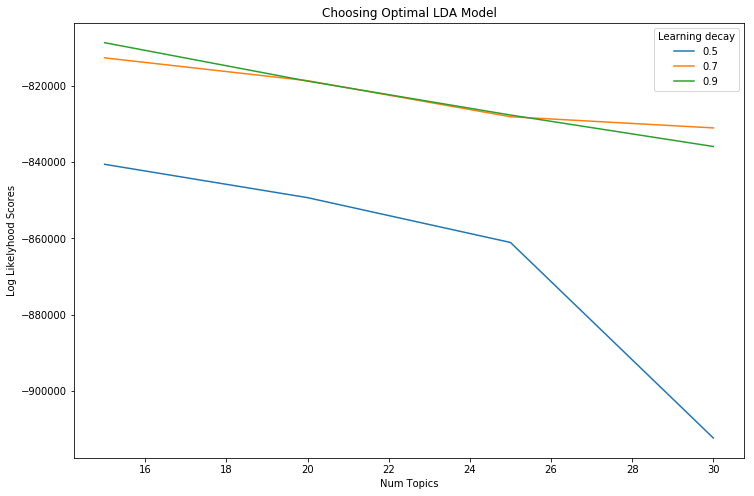

In [236]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Get Log Likelyhoods (higher better) from Grid Search Output
n_topics = [15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore) for i,gscore in enumerate(model.cv_results_['mean_test_score']) if
                     model.cv_results_['params'][i]['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore) for i,gscore in enumerate(model.cv_results_['mean_test_score']) if
                     model.cv_results_['params'][i]['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore) for i,gscore in enumerate(model.cv_results_['mean_test_score']) if
                     model.cv_results_['params'][i]['learning_decay']==0.9]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

# GuidedLDA 
[https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164](https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164)